# ResNet Experiments

Here we train the ResNet network and a ResNet network with Octave Convolution layers on the Tiny ImageNet challenge. We will eventually use the ResNet-50 network. We will eventually compare in terms of both accuracy and compute power expended.

## Setup

In [1]:
import os
import time
import random
import copy

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms, datasets

In [2]:
# Taken from 231n assignments
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


## Tiny ImageNet Data

We use the Tiny ImageNet database to benchmark some of our results. To download this dataset into your own workspace, run `$ wget http://cs231n.stanford.edu/tiny-imagenet-200.zip` from your command line. Then use the `$ unzip` command to unzip the dataset for use. The data directory should be `tiny-imagenet-200/`.

After that, we have to organize the `tiny-imagenet-200/val` to match the format of the `tiny-imagenet-200/train` directory, or else things break in annoying ways. To do this, run the script `./organize_val_imgs.sh` from the project directory. After that, we suggest you verify that the `val` and `train` directories are structured identically.

Further about Tiny ImageNet is located at https://tiny-imagenet.herokuapp.com/.

In [3]:
data_dir = 'tiny-imagenet-200/'

In [4]:
# Taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(10, shear=20),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print("Number of training examples in dataset: {}".format(len(image_datasets['train'])))
print("Number of validation examples in dataset: {}".format(len(image_datasets['val'])))

Number of training examples in dataset: 100000
Number of validation examples in dataset: 10000


In [5]:
# Create mini datasets for quick debugging

num_mini_samples = 100
for x in ['train', 'val']:
    mini_indices = random.sample(range(len(image_datasets[x])), k=num_mini_samples)
    mini_sampler = torch.utils.data.SubsetRandomSampler(mini_indices)
    dataloaders[x + '_mini'] = torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                            shuffle=False, num_workers=4,
                                                            sampler=mini_sampler)
    dataset_sizes[x + '_mini'] = dataloaders[x + '_mini'].batch_size * len(dataloaders[x + '_mini'])

print("Number of examples in train_mini: {}".format(dataset_sizes['train_mini']))
print("Number of examples in train_val: {}".format(dataset_sizes['val_mini']))

Number of examples in train_mini: 100
Number of examples in train_val: 100


In [6]:
def imshow(inp, title=None):
    """
    Imshow for Tensor.
    
    Code from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Image shape: torch.Size([3, 64, 64])
Image class: 18


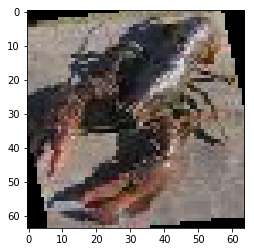

In [24]:
sample = image_datasets['train'][9402]
print("Image shape: {}".format(sample[0].shape))
print("Image class: {}".format(sample[1]))
imshow(sample[0])

In [25]:
# Make sure validation dataset is loaded properly
for inputs, labels in dataloaders["val"]:
    print("Validation minibatch labels: {}".format(labels))
    assert torch.sum(labels) != 0, "All validation labels are 0. Did you run organize_val_imgs.sh?"
    break

Validation minibatch labels: tensor([129,  44, 165,  69])


## Vanilla ResNet Model

Here we load the ResNet-50 model from torchvision.models

In [41]:
resnet = torchvision.models.resnet50(num_classes=200, pretrained=False)

## Training ResNet

In [42]:
# Taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_model(model, criterion, optimizer, save_path, log_file=None, scheduler=None, num_epochs=25, train_name='train', val_name='val'):
    """
    
    Parameters:
        model (Pytorch model): the model to train
        criterion (function): the loss function to optimize
        optimizer: a Pytorch optimizer object (e.g. Adam or SGD)
        save_path (string): the file to write the best model weights to at every validation step
        log_file (string): the file to write training stats (loss, accuracy history) to
        scheduler: learning rate schduler
        num_epochs (int): number of epochs to train
        train_name (string): can be set to 'train_mini' to train on mini set.
        val_name (string): can be set to 'val_mini' to validate on mini set
        
    Returns:
        The model with highest validation accuracy from our training history
    """
    since = time.time()

    model.to(device=device, dtype=dtype)    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # clear log_file:
    if log_file:
        open(log_file, 'w').close()
        with open(log_file, 'a') as f:
            f.write("Using optimizer: {}\n\n".format(optimizer))
    print("Using optimizer: {}\n\n".format(optimizer))

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in [train_name, val_name]:
            if phase == train_name:
                if scheduler:
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
#                 print("Iterating over batch of size {}".format(len(inputs)))
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == train_name):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == train_name:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # print and log training stats
            epoch_summary = 'Epoch: {}, {} Loss: {:.4f} Acc: {:.4f}'.format(
                epoch, phase, epoch_loss, epoch_acc)
            print(epoch_summary)
            if log_file:
                with open(log_file, "a") as f:
                    f.write(epoch_summary + "\n")

            # deep copy the best model, save weights to file
            if phase == val_name and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), save_path)
                print("Saved best model to {}".format(save_path))

        print()

    # Print and log timing stats
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    if log_file:
        with open(log_file, "a") as f:
            f.write('Training complete in {:.0f}m {:.0f}s\n'.format(
                    time_elapsed // 60, time_elapsed % 60))
            f.write('Best val Acc: {:4f}\n'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [43]:
loss_fn = nn.CrossEntropyLoss()
num_epochs = 100 # Jim's suggestion
momentum = 0.9 # Resnet paper
learning_rate = 1e-4
reg = 3e-2 # Resnet paper is 1e-4
optimizer = torch.optim.SGD(resnet.parameters(), momentum=momentum, lr=learning_rate, weight_decay=reg)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs) # OctConv paper

In [44]:
# Train on a mini dataset to debug
# The training accuracy should improve, and the val accuracy should be roughly random guessing
mini_epochs = 1 if device == 'cpu' else 5
mini_model = train_model(resnet, loss_fn, optimizer, 'saved_models/mini_resnet50.pth', 'logs/mini_resnet50.txt', scheduler=scheduler, num_epochs=mini_epochs, train_name='train_mini', val_name='val_mini')

Using optimizer: SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.0001
    lr: 0.0001
    momentum: 0.9
    nesterov: False
    weight_decay: 0.03
)


Epoch 0/4
----------
Epoch: 0, train_mini Loss: 5.5557 Acc: 0.0000
Epoch: 0, val_mini Loss: 5.6695 Acc: 0.0000

Epoch 1/4
----------
Epoch: 1, train_mini Loss: 5.1993 Acc: 0.0000
Epoch: 1, val_mini Loss: 6.5000 Acc: 0.0100
Saved best model to saved_models/mini_resnet50.pth

Epoch 2/4
----------
Epoch: 2, train_mini Loss: 4.9894 Acc: 0.0200
Epoch: 2, val_mini Loss: 5.9484 Acc: 0.0200
Saved best model to saved_models/mini_resnet50.pth

Epoch 3/4
----------
Epoch: 3, train_mini Loss: 4.8757 Acc: 0.0200
Epoch: 3, val_mini Loss: 6.7216 Acc: 0.0100

Epoch 4/4
----------
Epoch: 4, train_mini Loss: 4.7756 Acc: 0.0200
Epoch: 4, val_mini Loss: 6.4446 Acc: 0.0000

Training complete in 0m 15s
Best val Acc: 0.020000


In [45]:
def evaluate_model(model, criterion, val_name='val'):
    # Each epoch has a training and validation phase
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for i, (inputs, labels) in enumerate(dataloaders[val_name]):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes[val_name]
    epoch_acc = running_corrects.double() / dataset_sizes[val_name]

    print('Loss on {}: {:.4f} Acc: {:.4f}'.format(
        val_name, epoch_loss, epoch_acc))

In [46]:
evaluate_model(resnet, loss_fn, val_name='val_mini')

Loss on val_mini: 5.9484 Acc: 0.0200


## Training the Big Model

In [ ]:
# Train the actual big model
resnet = torchvision.models.resnet50(num_classes=200, pretrained=False)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 100 # Jim's suggestion
momentum = 0.9 # Resnet paper
learning_rate = 1e-4
reg = 3e-2 # Resnet paper is 1e-4
optimizer = torch.optim.SGD(resnet.parameters(), momentum=momentum, lr=learning_rate, weight_decay=reg)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs) # OctConv paper

best_resnet_path = 'saved_models/reg_res50.pth'
best_model = train_model(resnet, loss_fn, optimizer, best_resnet_path, log_file='logs/reg_res50.txt', scheduler=scheduler, num_epochs=num_epochs)

Using optimizer: SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.0001
    lr: 0.0001
    momentum: 0.9
    nesterov: False
    weight_decay: 0.03
)


Epoch 0/99
----------
Epoch: 0, train Loss: 5.3087 Acc: 0.0091
Epoch: 0, val Loss: 5.1834 Acc: 0.0181
Saved best model to saved_models/reg_res50.pth

Epoch 1/99
----------
Epoch: 1, train Loss: 5.0264 Acc: 0.0231
Epoch: 1, val Loss: 4.8101 Acc: 0.0368
Saved best model to saved_models/reg_res50.pth

Epoch 2/99
----------
Epoch: 2, train Loss: 4.8779 Acc: 0.0356
Epoch: 2, val Loss: 4.7533 Acc: 0.0517
Saved best model to saved_models/reg_res50.pth

Epoch 3/99
----------
Epoch: 3, train Loss: 4.8926 Acc: 0.0382
Epoch: 3, val Loss: 4.6915 Acc: 0.0512

Epoch 4/99
----------
Epoch: 4, train Loss: 4.9711 Acc: 0.0358
Epoch: 4, val Loss: 4.7975 Acc: 0.0435

Epoch 5/99
----------
Epoch: 5, train Loss: 5.0425 Acc: 0.0296
Epoch: 5, val Loss: 4.9301 Acc: 0.0366

Epoch 6/99
----------
Epoch: 6, train Loss: 5.0909 Acc: 0.0254
Epoch: 6, val Los